# Fine-tuning GPT-2 on a all recipes dataset in PyTorch



#### If you haven't yet, check out the notebook in this [gist](https://gist.github.com/mf1024/430d7fd6ff527350d3e4b5bda0d8614e) where use the same pretrained model to generate text.

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from os import listdir
from os.path import isfile, join

from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import os
import json
import re

import time

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [2]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
# model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

In [3]:
def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

### PyTorch Dataset module for Short jokes dataset

For fine-tuning the GPT2 model, I will use this [Short Jokes dataset](https://www.kaggle.com/abhinavmoudgil95/short-jokes) published on Kaggle. After each joke, I add "<|endofext|>" which is recognized by the GPT2 model as and end of text marker. The marker will allow me to concatenate many jokes in a single input sequence.

In [4]:
def clean_ingredients(ingredients):
    output = []
    for ingredient in ingredients:
#         values = removeChar(ingredient).split(" ")
#         values = values[1:]
#         for volume in ["\u2009"]:
#             if volume in values: values.remove(volume)
#         ingredient = " ".join(values)
        output.append(ingredient.replace("\u2009", ' '))
    return output

class RecipesDataset(Dataset):
    def __init__(self, recipes_dataset_path = 'C:/Users/Mech Punk/Documents/crawler/allrecipes'):
        super().__init__()

        recipefiles = [f for f in listdir(recipes_dataset_path) if isfile(join(recipes_dataset_path, f))]

        self.recipe_list = []
        self.title_token = "_tit" #"<|title|>"
        self.ingredients_token = "_ing" 
        self.instructions_token = "_ins" #"<|instructions|>"
        self.review_token = "_rev" #"<|review|>"
        self.rating_token = "_rat" #"<|rating|>"
        self.end_of_text_token = "_end" #"<|endoftext|>"
        self.categories_token = "_cat" #"<|endoftext|>"
        
        recipe_list = []
        for recipefile in recipefiles:
            path = os.path.join(recipes_dataset_path, recipefile)
            with open(path) as json_file:
                json_data = json.load(json_file)
                for recipe in json_data:
                    if "Three Cheese Italian Style Chicken Sausage Skillet" in recipe['title']:
                        continue
                    # Instructions
                    if type(recipe["recipeInstructions"]) != list:
                        recipe["recipeInstructions"] = [step[3:] for step in recipe["recipeInstructions"].split("Step")][1:]
                    recipeInstructions = ""
                    for step_index, step in enumerate(recipe["recipeInstructions"]):
                        recipeInstructions += f"Step {step_index+1} \n " + step.replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ")
                    recipeInstructions = recipeInstructions.replace("\n", " \n ").replace("  "," ")
                    # Ingredients
                    ingredients = ""
                    for ingredient in clean_ingredients(recipe["recipeIngredients"]):
                        ingredients += f" \n {ingredient}"
                    # Categories
                    categories = ""
                    for category in recipe["recipeCategory"]:
                        categories += f" \n {category}"
                    # Reviews
                    for review in recipe["ratings"]:
                        text = review["text"]
                        value = review["value"]
                        recipe_str = f"{self.title_token} {recipe['title']} {self.categories_token} {categories} {self.ingredients_token} {ingredients} {self.instructions_token} {recipeInstructions} {self.review_token} {text} {self.rating_token} {value} {self.end_of_text_token}"
                        self.recipe_list.append(recipe_str.replace("  "," "))
        
    def __len__(self):
        return len(self.recipe_list)

    def __getitem__(self, item):
        return self.recipe_list[item]


In [5]:
dataset = RecipesDataset()
recipe_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# tokenizer.add_special_tokens({'end_token': dataset.end_of_text_token})
# tokenizer.add_special_tokens({'title_token': dataset.title_token})
# tokenizer.add_special_tokens({'review_token': dataset.review_token})
# tokenizer.add_special_tokens({'instructions_token': dataset.instructions_token})
# tokenizer.add_special_tokens({'rating_token': dataset.rating_token})


In [20]:
dataset.recipe_list[10]

"_tit Dawn's Sugar Cookies _cat \n Desserts \n Cookies \n Sugar Cookies _ing \n 1 cup shortening \n 2 cups white sugar \n 4 eggs \n 1 teaspoon vanilla extract \n 4 cups all-purpose flour \n 2 teaspoons baking powder \n 1 teaspoon baking soda \n 1 cup buttermilk \n ½ cup butter, melted \n 2 cups confectioners' sugar \n 2 tablespoons milk \n 3 drops red food coloring _ins Step 1 \n Preheat oven to 350 degrees F (175 degrees C). Line cookie sheets with parchment paper. \n Step 2 \n In a large bowl, cream together the shortening and white sugar until smooth. Beat in eggs one at a time, and stir in vanilla. Combine the flour, baking powder, and baking soda; stir into the creamed mixture alternately with the buttermilk until a soft dough forms. Drop by teaspoonfuls onto prepared cookie sheets. \n Step 3 \n Bake for 10 minutes in preheated oven, or until light brown. Cool on wire racks. \n Step 4 \n In a medium bowl, blend together melted butter and confectioners' sugar until smooth. Graduall

In [17]:
recipes_dataset_path = 'C:/Users/Mech Punk/Documents/crawler/allrecipes'
recipefiles = [f for f in listdir(recipes_dataset_path) if isfile(join(recipes_dataset_path, f))]
recipe_list = []
for recipefile in recipefiles:
    path = os.path.join(recipes_dataset_path, recipefile)
#     print(path)
    with open(path) as json_file:
        json_data = json.load(json_file)
        for recipe in json_data:
            print(recipe["recipeCategory"])
            break
#             if type(recipe["recipeInstructions"]) == list:
#                 recipeInstructions = ""
#                 for step_index, step in enumerate(recipe["recipeInstructions"]):
#                     recipeInstructions += f"Step {step_index}\n " + step.replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ").replace("  "," ")
#             else:
#                 recipeInstructions = (recipe["recipeInstructions"]
#             recipe_str = f"Title {recipe["title"]: {recipeInstructions}}{self.end_of_text_token}"
#             self.recipe_list.append(recipe_str)
#             self.recipe_list.append(recipe_str)
#             print(len(recipe["recipeInstructions"]))
#             print(type(recipe["recipeInstructions"]))
#             if type(recipe["recipeInstructions"]) == list and len(recipe["recipeInstructions"]) > 1:
#                 break
#     if type(recipe["recipeInstructions"]) == list and len(recipe["recipeInstructions"]) > 1:
#         break
#     break

['Desserts', 'Cookies', 'Peanut Butter Cookies']
['Desserts', 'Cookies', 'Refrigerator Cookies']
['Side Dish', 'Sauces and Condiments', 'Sauces', 'Pasta Sauces', 'Meat Sauce']
['Soups, Stews and Chili', 'Soup', 'Vegetable Soup']
['Main Dishes', 'Burgers', 'Veggie']
['Main Dishes', 'Seafood Main Dishes', 'Crab']
['Salad', 'Curry Salad']
['Side Dish']
['Meat and Poultry', 'Chicken', 'Fried Chicken']
['Meat and Poultry', 'Beef', 'Steaks', 'Rib-Eye Steak']
['World Cuisine', 'Latin American', 'Mexican']
['Soups, Stews and Chili', 'Soup', 'Vegetable Soup']
['Desserts', 'Fruit Desserts', 'Apple Desserts']
['Bread', 'Yeast Bread']
['World Cuisine', 'European', 'Italian']
['Side Dish', 'Potato Side Dishes', 'Roasted Potatoes']
[]
[]
[]
[]
[]
[]
['World Cuisine', 'European', 'Eastern European', 'Czech']
[]
[]
[]
['Meat and Poultry', 'Pork', 'Pork Ribs', 'Baby Back Ribs']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Desserts', 'Fruit Desserts', 'Strawberry Desserts']
['World Cuisine', 'European

'For easy cutting line the pan with wax paper or foil. Leave about 1 inch over hang on the ends. Place ingredients inside allow to set as directed. Remove from pan by edges of foil/paper and use a pizza cutter to cut into nice smooth squares. We use this method with all desserts/bars that need to be cut!'

5

531

In [47]:
# recipe["recipeInstructions"]

In [48]:
# recipes_dataset_path = 'C:/Users/Mech Punk/Documents/crawler/allrecipes'
# recipefiles = [f for f in listdir(recipes_dataset_path) if isfile(join(recipes_dataset_path, f))]

In [43]:
recipeInstructions

'Step 0\n Preheat the oven to 375 degrees F (190 degrees C). Grease a 12 cup muffin tin, or line with paper muffin liners.\n Step 1\n In a large bowl, stir together the flour, sugar substitute, baking powder, baking soda, and cinnamon. In a separate bowl, mix together the egg whites, mashed banana and applesauce. Add the wet ingredients to the dry, and mix until just blended. Fill prepared muffin cups 3/4 full.\n Step 2\n Bake for 15 to 18 minutes in the preheated oven, or until the top springs back when lightly touched. Allow muffins to cool in the pan over a wire rack for a little while before tapping them out of the pan.\n '

In [13]:
dataset = RecipesDataset()
recipe_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [14]:
len(dataset)

20996

In [77]:
np.sum(["Three Cheese Italian Style Chicken Sausage Skillet" in recipe for recipe in dataset.recipe_list])

10809

In [12]:
dataset.recipe_list[1]

"_tit Chocolate Peanut Butter Bars II _cat \n Desserts \n Cookies \n Peanut Butter Cookies _ing \n ½ cup butter \n ½ cup packed brown sugar \n 1 teaspoon vanilla extract \n 2 cups peanut butter \n 2 ½ cups confectioners' sugar \n 2 cups semisweet chocolate chips _ins Step 1 \n Melt butter or margarine over low heat. Add sugars, peanut butter and vanilla. Mix well. \n Step 2 \n Press into a 9 x 13 inch pan. \n Step 3 \n Melt chocolate chips and spread over the top. Cool. \n _rev For easy cutting line the pan with wax paper or foil. Leave about 1 inch over hang on the ends. Place ingredients inside allow to set as directed. Remove from pan by edges of foil/paper and use a pizza cutter to cut into nice smooth squares. We use this method with all desserts/bars that need to be cut! _rat 5 _end"

In [66]:
len(dataset.recipe_list)

30630

### Hyperparameters

I tested many(more than 5) hyperparameter sets till I found one that works the best. I mostly tuned ***BATCH_SIZE*** (in this case, it's the number of forward-backward passes between each optimization step), ***EOPOCHS***, and ***LEARNING_RATE***.

For a parameter value starting point for fine-tuning, I inspired from [this](https://github.com/huggingface/transformers/blob/master/examples/run_squad.py) and [this](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) huggingface fine-tuning code.

In [5]:
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
WARMUP_STEPS = 5000
MAX_SEQ_LEN = 800 #400
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup as WarmupLinearSchedule


device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.current_device()

0

### Model training

I will train the model and save the model weights after each epoch and then I will try to generate recipes with each version of the weight to see which performs the best.

In [9]:
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = WarmupLinearSchedule(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

tmp_recipes_tens = None
models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

    
for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    counter=0
    for idx,recipe in enumerate(recipe_loader):
#         print(counter)
        counter+=1
        
#         print('a')
        
        #################### "Fit as many recipe sequences into MAX_SEQ_LEN sequence as possible" logic start ####
        recipe_tens = torch.tensor(tokenizer.encode(recipe[0])).unsqueeze(0).to(device)
        #Skip sample from dataset if it is longer than MAX_SEQ_LEN
        if recipe_tens.size()[1] > MAX_SEQ_LEN:
            continue
            
#         print('b')
        
        #The first recipe sequence in the sequence
        if not torch.is_tensor(tmp_recipes_tens):
            tmp_recipes_tens = recipe_tens
            continue
        else:
            #The next recipe does not fit in so we process the sequence and leave the last recipe 
            #as the start for next sequence 
            if tmp_recipes_tens.size()[1] + recipe_tens.size()[1] > MAX_SEQ_LEN:
                work_recipes_tens = tmp_recipes_tens
                tmp_recipes_tens = recipe_tens
            else:
                #Add the recipe to sequence, continue and try to add more
                tmp_recipes_tens = torch.cat([tmp_recipes_tens, recipe_tens[:,1:]], dim=1)
                continue
        ################## Sequence ready, process it trough the model ##################
            
            
#         print('c')
        
        outputs = model(work_recipes_tens, labels=work_recipes_tens)
        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
#     torch.save(model.state_dict(), os.path.join(models_folder, f"gpt2_medium_reciper_{epoch}.pt"))
    torch.save(model.state_dict(), os.path.join(models_folder, f"gpt2_recipe_reviews_ingredients_categories_2_{epoch}.pt"))
            

EPOCH 0 started==============================
sum loss 5173.7412109375
sum loss 4664.78955078125
sum loss 4324.77978515625
sum loss 4054.224365234375
sum loss 3865.771728515625
sum loss 3678.900146484375
sum loss 3572.981689453125
sum loss 3498.683837890625
sum loss 3432.91357421875
sum loss 3374.886962890625
sum loss 3346.14404296875
sum loss 3312.210693359375
sum loss 3269.261962890625
sum loss 3238.20068359375
sum loss 3215.717529296875
sum loss 3182.832763671875
sum loss 3161.5302734375
sum loss 3118.53369140625
sum loss 3119.603271484375
sum loss 3092.09326171875
sum loss 3060.978271484375
sum loss 3059.291748046875
sum loss 3043.237060546875
sum loss 3027.92236328125
sum loss 2990.117431640625
sum loss 2970.294189453125
sum loss 2946.73388671875
sum loss 2961.415771484375
sum loss 2923.640625
sum loss 2934.487548828125
sum loss 2920.230712890625
sum loss 2897.19287109375
sum loss 2862.266357421875
sum loss 2872.746337890625
sum loss 2856.159912109375
sum loss 2846.729736328125
su

In [12]:
# torch.save(model.state_dict(), os.path.join(models_folder, f"gpt2_joker_{epoch}.pt"))

In [26]:
proc_seq_count

0

### Generating the jokes

In [8]:
def recipe_to_dict(recipe_text):
    current = recipe_text.split("_tit")[1]
#     print(current)
    splitted = current.split("_cat ")
    (title, current) = splitted[0], splitted[1]
#     print("title", title)
    splitted = current.split("_ing")
    (categories, current) = splitted[0], splitted[1]
#     print("\n categories", ingredients)
    splitted = current.split("_ins")
    (ingredients, current) = splitted[0], splitted[1]
#     print("\n ingredients", ingredients)
    splitted = current.split("_rev")
    (instructions, current) = splitted[0], splitted[1]
#     print("\n instructions", instructions)
    splitted = current.split("_rat")
    (review, current) = splitted[0], splitted[1]
#     print("\n review", review)
    splitted = current.split("_end")
    (rating, _) = splitted[0], splitted[1]
#     print("\n rating", rating)

    categories = [category.strip() for category in categories.strip().split("\n")]
    ingredients = ingredients.strip().replace("  ", " ").split("\n")
    ingredients = [ingredient.strip() for ingredient in ingredients]
    instructions = [instruction[2:] for instruction in instructions.strip().replace("\n","").replace("  ", " ").split("Step ")[1:]]
    recipe = {
        "title": title,
        "categories": categories,
        "ingredients": ingredients,
        "instructions": instructions,
        "reviews": [review],
        "ratings": [int(rating)],
        
    }
    return recipe
# recipe_to_dict(output_text)

In [42]:
def complete_recipe_generator(title="", categories=[], ingredients=[], instructions=[], 
                              number_of_reviews=[5, 10], max_length=1000,
                             title_tag="_tit", categories_tag="_cat", ingredients_tag="_ing", instructions_tag="_ins"):
    primer = f"{title_tag} "+ title
    if len(categories) > 0:
        primer += f" {categories_tag} "
        for category in categories:
            primer += f"{category} \n "
            
    if len(ingredients) > 0:
        assert len(categories) > 0; "You need to add categories before ingredients"
        primer += f"{ingredients_tag} "
        for ingredient in ingredients:
            primer += f"\n {ingredient} "
           
    if len(instructions) > 0:
        assert len(ingredients) > 0; "You need to add ingredients before instructions"
        primer += f"{instructions_tag} "
        for instruction_index, instruction in enumerate(instructions):
            primer += f"Step {instruction_index+1} \n {instruction}" 
    
    output_text, recipe_finished = generate_recipe(primer, max_length=max_length)

    # Check if it completed synthesis
    if recipe_finished == False:
        return None, primer

    # Create it into a recipe dictionary
    try:
        recipe = recipe_to_dict(output_text)
    except:
        print("Recipe is in the wrong format")
        return None, primer
        
    # Add more reviews
    for i in range(np.random.randint(number_of_reviews[0], number_of_reviews[1])):
        try:
            i_text, recipe_finished = generate_recipe(output_text.split("_rev")[0] + "_rev")
        except:
            print("probably recipy too long")
            continue
        try:
            i_recipe = recipe_to_dict(i_text)
            recipe["reviews"].append(i_recipe["reviews"][0])
            recipe["ratings"].append(i_recipe["ratings"][0])
        except:
            continue

    return recipe, primer

In [43]:
recipe, primer = complete_recipe_generator("Apple pie", 
                          ["Desserts", "Pies", "Apple Pie"], 
                          ['1 cup all-purpose flour',
                          '1 ½ teaspoons salt',
                          '1 cup white sugar',
                          '½ cup butter',
                          '1 egg',
                          '1 ½ teaspoons vanilla extract',
                          '1 teaspoon ground cinnamon',
                          '1 cup chopped pecans'],
                          ["If you wish to make apple pie from scratch, you must first"])

In [44]:
recipe

{'title': ' Apple pie ',
 'categories': ['Desserts', 'Pies', 'Apple Pie'],
 'ingredients': ['1 cup all-purpose flour',
  '1 ½ teaspoons salt',
  '1 cup white sugar',
  '½ cup butter',
  '1 egg',
  '1 ½ teaspoons vanilla extract',
  '1 teaspoon ground cinnamon',
  '1 cup chopped pecans'],
 'instructions': ['If you wish to make apple pie from scratch, you must first beat the flour and sugar together until well combined. ',
  'Preheat oven to 325 degrees F (165 degrees C). ',
  'Combine the egg, vanilla, cinnamon, and pecans in a medium bowl and stir into the flour mixture. Stir until well blended. ',
  'Pour batter into an ungreased 9x13 inch pan. Bake at 325 degrees F (165 degrees C) for 45 minutes, or until a toothpick inserted into the center of the pie comes out clean.'],
 'reviews': [' This is a great recipe for apple pie. I used 1/4 c. butter and 1 1/2 cups white sugar. It was very good. I used a pastry bag instead of an ungreased 9x13 pan and used 1 1/2 c. sugar and 1 1/2 c. apple

In [45]:
primer

'_tit Apple pie _cat Desserts \n Pies \n Apple Pie \n _ing \n 1 cup all-purpose flour \n 1 ½ teaspoons salt \n 1 cup white sugar \n ½ cup butter \n 1 egg \n 1 ½ teaspoons vanilla extract \n 1 teaspoon ground cinnamon \n 1 cup chopped pecans _ins Step 1 \n If you wish to make apple pie from scratch, you must first'

In [10]:
def generate_recipe(primer="_tit", max_length=1000):

    with torch.no_grad():
        recipe_finished = False

        cur_ids = torch.tensor(tokenizer.encode(primer)).unsqueeze(0).to(device)

        for i in range(max_length):
            if cur_ids.shape[1] > max_length:
                break
            outputs = model(cur_ids, labels=cur_ids)
            loss, logits = outputs[:2]
            softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
            if i < 3:
                n = 20
            else:
                n = 3
            next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
            cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

            if next_token_id in tokenizer.encode('_end'):
                recipe_finished = True
                break

        output_text = ""
        if recipe_finished:

            output_list = list(cur_ids.squeeze().to('cpu').numpy())
            output_text = tokenizer.decode(output_list)
            # This is just temporary:
#             output_text = output_text.replace("\u2009", '')

        return output_text, recipe_finished

In [15]:
MODEL_EPOCH = 4
models_folder = "trained_models"
model_path = os.path.join(models_folder, f"gpt2_recipe_reviews_ingredients_categories_2_{MODEL_EPOCH}.pt")
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [11]:


safe_file = 'recipes_3_b.json'

try:
    with open(safe_file, 'r') as file:
        recipes = json.load(file)
except:
    recipes = []
    


# model_path = os.path.join(models_folder, f"gpt2_medium_joker_{MODEL_EPOCH}.pt")

recipes_output_file_path = f'generated_{MODEL_EPOCH}_reviews_ingredients_categories.recipe'

model.eval()
if os.path.exists(recipes_output_file_path):
    os.remove(recipes_output_file_path)
    
recipe_num = 0
for recipe_idx in range(1000):
   
    # Generate recipe
    output_text, recipe_finished = generate_recipe("_tit")

    # Check if it completed synthesis
    if recipe_finished == False:
        continue

    # Create it into a recipe dictionary
    try:
        recipe = recipe_to_dict(output_text)
    except:
        print("Recipe is in the wrong format")
        continue
        
    # Add more reviews
    for i in range(np.random.randint(5,10)):
        try:
            i_text, recipe_finished = generate_recipe(output_text.split("_rev")[0] + "_rev")
        except:
            print("probably recipy too long")
            continue
        try:
            i_recipe = recipe_to_dict(i_text)
            recipe["reviews"].append(i_recipe["reviews"][0])
            recipe["ratings"].append(i_recipe["ratings"][0])
        except:
            continue
        
    # Add recipe to list
    recipe["id"]=f"{int(time.time())}-{recipe_idx}"
    recipes.append(recipe)
    
    # Save all recipes
    with open(safe_file, 'w') as file:
        file.write(json.dumps(recipes, sort_keys=True, indent=4, separators=(',', ': ')))
        
    break



KeyboardInterrupt: 

In [24]:

categories

['Soups, Stews and Chili', 'Soup', 'Vegetable Soup']

In [88]:
recipe

{'title': ' Baked Zucchini ',
 'ingredients': ['2 pounds zucchini, cut into wedges',
  '1 cup butter',
  '2 eggs',
  '½ teaspoon salt',
  '¼ cup milk',
  '2 teaspoons ground cumin',
  '¼ teaspoon ground black pepper',
  '1 cup shredded sharp Cheddar cheese',
  '1\u2009½ cups shredded Swiss cheese',
  '1\u2009½ cups shredded mozzarella cheese'],
 'instructions': ['Preheat oven to 400 degrees F (200 degrees C). Grease a 9x13 inch baking dish. ',
  'Melt butter in a skillet over medium-high heat. Add eggs one at a time, and saute until lightly browned. Add salt, milk, and cumin. Stir in cheese, and cook until melted and bubbly. ',
  'In a large bowl, combine zucchini, melted butter, eggs, salt, and cheese; mix well. Spread into prepared baking dish. ',
  'Bake in preheated oven for 30 minutes, or until heated through.'],
 'reviews': [' My husband loves this recipe! He has never had zucchini before so I made this for him and he loved it. I used the same recipe as he had but he loved the zu

In [73]:
text, recipe_finished = generate_recipe("_tit")
text

'_tit Chicken Casserole I _cat \n Meat and Poultry \n Chicken \n Chicken Breasts \n Skillet _ing \n 2 (10.75 ounce) cans condensed cream of chicken soup \n 2 (10.75 ounce) cans condensed cream of mushroom soup \n 1 (8 ounce) package frozen whipped topping, thawed \n 1 (8 ounce) package frozen whipped topping, thawed \n 1 (8 ounce) package frozen chopped spinach, thawed \n 1 (4 ounce) can sliced green chile peppers, with juice \n 1 (16 ounce) package shredded Cheddar cheese _ins Step 1 \n In a large skillet over medium heat, combine soup, mushroom soup, whipped topping and frozen spinach. Cook until spinach is tender, about 10 minutes. Drain and set aside. \n Step 2 \n In a large bowl, mix together spinach, green chile pepper, Cheddar cheese and spinach mixture. Pour mixture over chicken and serve. \n _rev I made this recipe for a party and everyone raved about how it was delicious and easy to make. I used a can of cream of chicken soup and a can of cream of mushroom and it was a hit. I

'_tit Chicken Casserole I _cat \n Meat and Poultry \n Chicken \n Chicken Breasts \n Skillet _ing \n 2 (10.75 ounce) cans condensed cream of chicken soup \n 2 (10.75 ounce) cans condensed cream of mushroom soup \n 1 (8 ounce) package frozen whipped topping, thawed \n 1 (8 ounce) package frozen whipped topping, thawed \n 1 (8 ounce) package frozen chopped spinach, thawed \n 1 (4 ounce) can sliced green chile peppers, with juice \n 1 (16 ounce) package shredded Cheddar cheese _ins Step 1 \n In a large skillet over medium heat, combine soup, mushroom soup, whipped topping and frozen spinach. Cook until spinach is tender, about 10 minutes. Drain and set aside. \n Step 2 \n In a large bowl, mix together spinach, green chile pepper, Cheddar cheese and spinach mixture. Pour mixture over chicken and serve. \n _rev'

In [86]:
text, recipe_finished = generate_recipe(text.split("_rev")[0] + "_rev")
a,b = text.split("_rev")
print(a)
print("")
print(b)

_tit Chicken Casserole I _cat 
 Meat and Poultry 
 Chicken 
 Chicken Breasts 
 Skillet _ing 
 2 (10.75 ounce) cans condensed cream of chicken soup 
 2 (10.75 ounce) cans condensed cream of mushroom soup 
 1 (8 ounce) package frozen whipped topping, thawed 
 1 (8 ounce) package frozen whipped topping, thawed 
 1 (8 ounce) package frozen chopped spinach, thawed 
 1 (4 ounce) can sliced green chile peppers, with juice 
 1 (16 ounce) package shredded Cheddar cheese _ins Step 1 
 In a large skillet over medium heat, combine soup, mushroom soup, whipped topping and frozen spinach. Cook until spinach is tender, about 10 minutes. Drain and set aside. 
 Step 2 
 In a large bowl, mix together spinach, green chile pepper, Cheddar cheese and spinach mixture. Pour mixture over chicken and serve. 
 

 I made this last night for a family gathering and it was a big hit with everyone. I added some shredded Cheddar cheese and some shredded Cheddar cheese and it was a big hit! _rat 4 _end


In [75]:
recipe = recipe_to_dict(text)
recipe

{'title': ' Chicken Casserole I ',
 'ingredients': ['2 (10.75 ounce) cans condensed cream of chicken soup',
  '2 (10.75 ounce) cans condensed cream of mushroom soup',
  '1 (8 ounce) package frozen whipped topping, thawed',
  '1 (8 ounce) package frozen whipped topping, thawed',
  '1 (8 ounce) package frozen chopped spinach, thawed',
  '1 (4 ounce) can sliced green chile peppers, with juice',
  '1 (16 ounce) package shredded Cheddar cheese'],
 'instructions': ['In a large skillet over medium heat, combine soup, mushroom soup, whipped topping and frozen spinach. Cook until spinach is tender, about 10 minutes. Drain and set aside. ',
  'In a large bowl, mix together spinach, green chile pepper, Cheddar cheese and spinach mixture. Pour mixture over chicken and serve.'],
 'reviews': [' I made this recipe for a party and everyone raved about how it was delicious and easy to make. I used a can of cream of chicken soup and a can of cream of mushroom and it was a hit. I also added some shredded

'_title":"Grandma Tanya\'s Chocolate Chip Cookies _cat \n Desserts \n Cookies \n Drop Cookies \n Chocolate Chip Cookies _ing \n 1 cup butter \n 1 cup white sugar \n ½ cup packed brown sugar \n ½ cup butter, softened \n 1 teaspoon vanilla extract \n 1 cup all-purpose flour \n 1 teaspoon baking soda \n 1 cup semisweet chocolate chips \n 2 eggs \n 1\u2009⅓ cups confectioners\' sugar \n 2 teaspoons vanilla extract \n 1 cup semisweet chocolate chips _ins Step 1 \n Preheat oven to 325 degrees F (165 degrees C). Grease cookie sheets. \n Step 2 \n Cream the butter or margarine and white sugar. Add the brown sugar and butter. Mix in the vanilla and flour. Stir in the chocolate chips, eggs, confectioners\' sugar and vanilla until smooth. Drop by rounded teaspoons on cookie sheets. \n Step 3 \n Bake for 8 to 10 minutes. Cool on wire racks. \n Step 4 \n In a large bowl, beat the chocolate chips and eggs together. Stir in the confectioners\' sugar and vanilla until smooth. Spread evenly over cookie

In [57]:
recipes[]

[{'title': 'le ',
  'ingredients': ['2 cups all-purpose flour',
   '½ teaspoon baking powder',
   '¾ teaspoon salt',
   '½ cup white sugar',
   '1 egg',
   '2 cups rolled oats',
   '1 cup butter, melted',
   "1\u2009½ cups confectioners' sugar"],
  'instructions': ['Preheat oven to 350 degrees F (175 degrees C). ',
   'In a medium bowl, mix together flour, baking powder and salt. Cut in the white sugar. Stir in eggs one at a time until blended. Stir in the rolled oats. ',
   'Drop dough by teaspoonfuls onto ungreased baking sheets. Bake for 8 minutes in the preheated oven. Remove to wire racks to cool completely.'],
  'reviews': [' My family and I love these cookies. They are so easy to make. I used 1 cup of flour and 2/3 cup of confectioners sugar. The dough was very soft. I did not have to add any flour. I also added 2 cups of milk to make it more moist. I also used 1/4 cup butter instead of the 2 cups of butter. '],
  'ratings': [5]},
 {'title': 'le-21-11-19 ',
  'ingredients': ['2 

In [ ]:
## Let's make some freaking apple pi!

In [ ]:
# recipe, primer = complete_recipe_generator("Apple pie", 
#                           ["Desserts", "Pies", "Apple Pie"], 
#                           [])
# recipe

In [49]:
# recipe, primer = complete_recipe_generator("Apple pie", 
#                           ["Desserts", "Pies", "Apple Pie"], 
#                           ['1 cup all-purpose flour',
#                           '1 ½ teaspoons salt',
#                           '1 cup white sugar',
#                           '½ cup butter',
#                           '1 egg',
#                           '1 ½ teaspoons vanilla extract',
#                           '1 teaspoon ground cinnamon',
#                           '1 cup chopped pecans'],
#                           ["If you wish to make apple pie from scratch, you must first"])

In [56]:
# recipe, primer = complete_recipe_generator("Space cake _cat")
# recipe

In [59]:
# recipe, primer = complete_recipe_generator("Cream pie _cat")
# recipe

In [62]:
# recipe, primer = complete_recipe_generator("Dead rat _cat")
# recipe

In [65]:
# recipe, primer = complete_recipe_generator("Guinea pig _cat")
# recipe

In [64]:
safe_file = 'recipes_custom.json'

try:
    with open(safe_file, 'r') as file:
        recipes = json.load(file)
except:
    recipes = []


# Add recipe to list
recipe["id"]=f"{int(time.time())}-C"
recipes.append(recipe)

# Save all recipes
with open(safe_file, 'w') as file:
    file.write(json.dumps(recipes, sort_keys=True, indent=4, separators=(',', ': ')))

In [3]:
encoded = tokenizer.encode("Preheat oven to 325 degrees F (165 degrees C). Lightly grease cookie")

In [12]:
to_predict = tokenizer.encode(" sheets.")
to_predict

[15747, 13]

In [4]:
encoded

[6719,
 25080,
 14361,
 284,
 29524,
 7370,
 376,
 357,
 20986,
 7370,
 327,
 737,
 4401,
 306,
 35537,
 19751]

In [15]:
dictionary  = tokenizer.get_vocab()

In [16]:
inverse_dictionary = {}
for key in dictionary:
    value = dictionary[key]
    inverse_dictionary[value]=key

In [11]:
for code in encoded:
    print(inverse_dictionary[code], code)

Pre 6719
heat 25080
Ġoven 14361
Ġto 284
Ġ325 29524
Ġdegrees 7370
ĠF 376
Ġ( 357
165 20986
Ġdegrees 7370
ĠC 327
). 737
ĠLight 4401
ly 306
Ġgrease 35537
Ġcookie 19751


In [13]:
to_do = ""
for code in encoded:
    to_do+=f"{code}, "
to_do+=f"-> {to_predict[0]}"
to_do

'6719, 25080, 14361, 284, 29524, 7370, 376, 357, 20986, 7370, 327, 737, 4401, 306, 35537, 19751, -> 15747'

In [17]:
cur_ids = torch.tensor(encoded).unsqueeze(0).to(device)

In [18]:
cur_ids

tensor([[ 6719, 25080, 14361,   284, 29524,  7370,   376,   357, 20986,  7370,
           327,   737,  4401,   306, 35537, 19751]], device='cuda:0')

In [32]:
with torch.no_grad():
    outputs = model(cur_ids, labels=cur_ids)
    loss, logits = outputs[:2]
    softmax_logits = torch.softmax(logits[0,-1], dim=0) 
    output = softmax_logits.to('cpu').numpy()

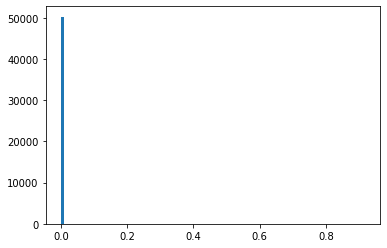

In [38]:
_ = plt.hist(output,bins=100)

In [41]:
possibilities = (output > 0.01)

In [42]:
np.argwhere(output > 0.01)

array([[ 9629],
       [15747]], dtype=int64)

In [34]:
from matplotlib import pyplot as plt

In [46]:
inverse_dictionary[15747]

'Ġsheets'

In [47]:
inverse_dictionary[9629]

'Ġsheet'

In [48]:
np.where(output > 0.01)

(array([ 9629, 15747], dtype=int64),)

In [49]:
output[15747]

0.9185744

In [50]:
output[9629]

0.076905936

In [22]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('gpt2') 
word_embeddings = model.transformer.wte.weight 
# position_embeddings = model.transformer.wpe.weight 

In [52]:
word_embeddings

Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True)

In [58]:
with torch.no_grad():
    embedding_matrix = word_embeddings.detach().numpy()

In [60]:
embedding_matrix.shape

(50257, 768)

In [62]:
man_token = dictionary["man"]

In [64]:
man_vector = embedding_matrix[man_token,:]

In [65]:
woman_token = dictionary["woman"]

In [66]:
woman_vector = embedding_matrix[woman_token,:]

In [67]:
car_token = dictionary["car"]

In [68]:
car_vector = embedding_matrix[car_token,:]

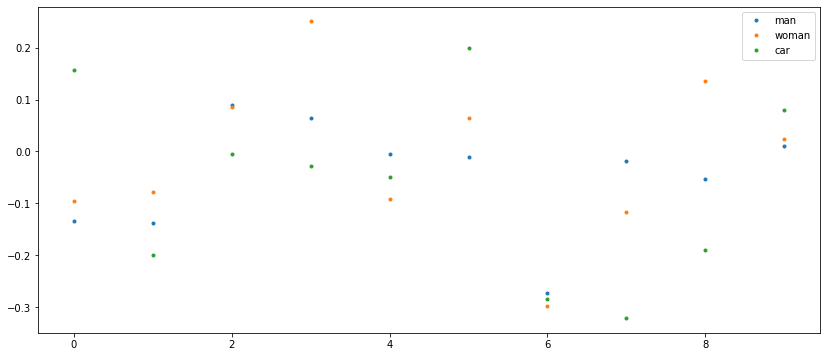

In [79]:
plt.figure(figsize=(14,6))
plt.plot(man_vector[:10], '.')
plt.plot(woman_vector[:10], '.')
plt.plot(car_vector[:10], '.')
plt.legend(["man","woman","car"])

In [147]:
king_token = dictionary["king"]

In [148]:
king_vector = embedding_matrix[king_token,:]

In [149]:
maybe_queen_vector = king_vector - man_vector + woman_vector

In [150]:
maybe_queen_difference_matrix = embedding_matrix - maybe_queen_vector[np.newaxis,:]

In [151]:
maybe_queen_differences = np.sum(np.abs(maybe_queen_difference_matrix),axis=1)

In [152]:
maybe_queen_indices, maybe_queen_values = np.argsort(maybe_queen_differences, ), np.sort(maybe_queen_differences)

In [153]:
[inverse_dictionary[key] for key in maybe_queen_indices[1:10:]]

['woman', 'ked', 'KING', 'women', 'King', 'Lady', 'ĝ', 'ă', 'é¾įå¥']

In [158]:
probe_token = dictionary["plane"]
probe_vector = embedding_matrix[probe_token,:]
probe_difference_matrix = embedding_matrix - probe_vector[np.newaxis,:]
probe_differences = np.sum(np.abs(probe_difference_matrix),axis=1)
probe_indices, probe_values = np.argsort(probe_differences, ), np.sort(probe_differences)
[inverse_dictionary[key] for key in probe_indices[1:10:]]

['planes',
 'Ġplane',
 'Ġplanes',
 'ĠPlane',
 'Ġairplane',
 'Ġaircraft',
 'Ġairplanes',
 'Ġjet',
 'ē']

In [159]:
def get_closest(probe):
    probe_token = dictionary[probe]
    probe_vector = embedding_matrix[probe_token,:]
    probe_difference_matrix = embedding_matrix - probe_vector[np.newaxis,:]
    probe_differences = np.sum(np.abs(probe_difference_matrix),axis=1)
    probe_indices, probe_values = np.argsort(probe_differences, ), np.sort(probe_differences)
    return [inverse_dictionary[key] for key in probe_indices[1:10:]]

In [160]:
get_closest("plane")

['planes',
 'Ġplane',
 'Ġplanes',
 'ĠPlane',
 'Ġairplane',
 'Ġaircraft',
 'Ġairplanes',
 'Ġjet',
 'ē']

In [161]:
get_closest("cat")

['Cat', 'cats', 'Ġcat', 'ĠCat', 'Ġcats', 'c', 'ø', 'ę', 'č']

In [162]:
get_closest("dog")

['dogs', 'Ġdog', 'Dog', 'ĠDog', 'Ġdogs', 'ĠDogs', 'ć', 'Á', 'ú']

In [163]:
get_closest("building")

['Ġbuilding',
 'builders',
 'Building',
 'ĠBuilding',
 'builder',
 'build',
 'Ġconstructing',
 'Ġbuilders',
 'Ġbuild']

In [164]:
get_closest("house")

['houses',
 'Ġhouse',
 'House',
 'ĠHouse',
 'Ġhouses',
 'ĠHOUSE',
 'Ġin',
 'Ġand',
 'Ġwith']

In [165]:
get_closest("computer")

['Computer',
 'Ġcomputer',
 'ĠComputer',
 'Ġcomputers',
 'Ġcomputational',
 'ú',
 'Ď',
 'ü',
 'ď']

In [17]:
len(dictionary)

50257

In [11]:
sentence = " ".join(["hi" for _ in range(1024)])

encoded = tokenizer.encode(sentence)

In [12]:
cur_ids = torch.tensor(encoded).unsqueeze(0).to(device)

In [13]:
# model = model.to(device)
with torch.no_grad():
    outputs = model(cur_ids, labels=cur_ids)
    loss, logits = outputs[:2]
    softmax_logits = torch.softmax(logits[0,-1], dim=0) 
    output = softmax_logits.to('cpu').numpy()
output

array([4.1368643e-05, 2.8269228e-06, 5.0701726e-07, ..., 4.2566777e-09,
       9.8345931e-10, 3.1883785e-05], dtype=float32)

In [14]:
len(encoded)

1024

In [18]:
50257 * 1024

51463168

In [20]:
tokenizer.encode("    ")

[]

In [21]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}